In [67]:
! pip install torch torchvision numpy matplotlib pillow


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import copy

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

content_img_path = 'Pictures/Pic1.jpg'  # Mona Lisa
style_img_path = 'Pictures/Pic2.jpg'    # Starry Night

Using device: cpu


In [74]:
imsize = 512

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # Force exact same dimensions
    transforms.ToTensor()])

def image_loader(image_path):
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [75]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image.clip(0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

In [76]:
content_img = image_loader(content_img_path)
style_img = image_loader(style_img_path)

assert style_img.size() == content_img.size(), \
    "Style and content images need to be the same size"

In [77]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = F.mse_loss(self.target, self.target)

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

In [78]:
def gram_matrix(input):
    batch_size, f_maps, h, w = input.size()
    features = input.view(batch_size * f_maps, h * w)
    G = torch.mm(features, features.t())
    return G.div(batch_size * f_maps * h * w)

In [79]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = F.mse_loss(self.target, self.target)

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

In [80]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [81]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [82]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [83]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=200,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

In [84]:
input_img = content_img.clone()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=200)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 79.674133 Content Loss: 23.634418

run [100]:
Style Loss : 7.965422 Content Loss: 20.787912

run [150]:
Style Loss : 4.650615 Content Loss: 16.305609

run [200]:
Style Loss : 2.615552 Content Loss: 13.863323



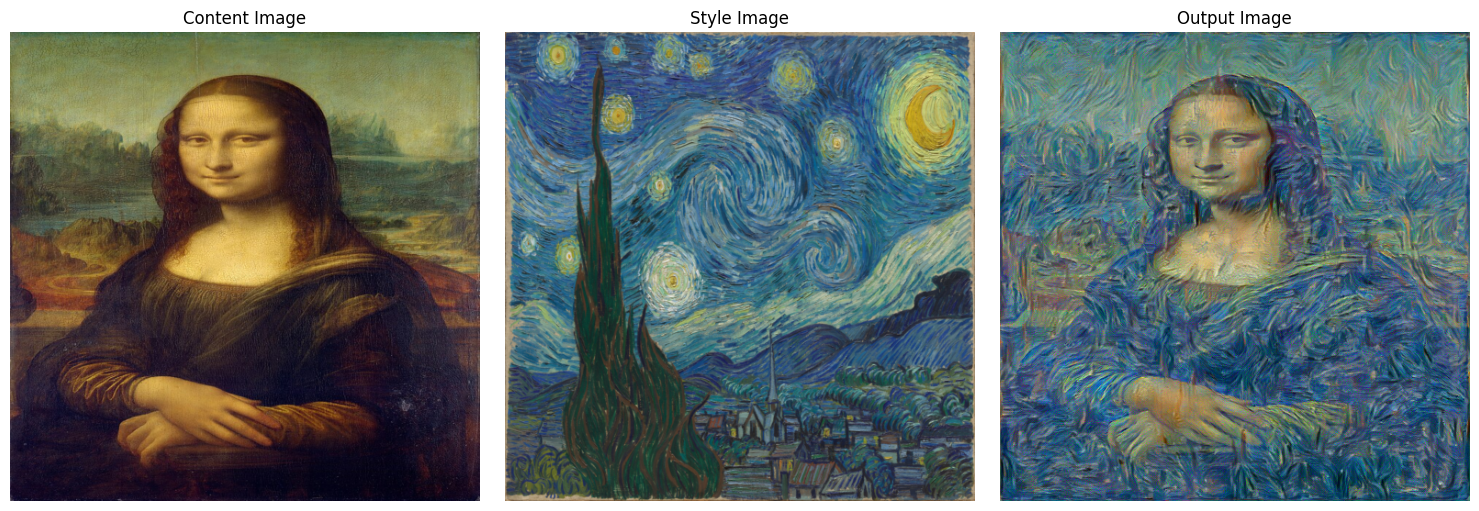

In [85]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
imshow(content_img, title='Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
imshow(style_img, title='Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
imshow(output, title='Output Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [86]:
def save_image(tensor, filename):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    tensor = tensor.numpy().transpose(1, 2, 0)
    tensor = np.clip(tensor, 0, 1)
    tensor = (tensor * 255).astype(np.uint8)
    img = Image.fromarray(tensor)
    img.save(filename)

save_image(output, 'final_stylized_output.jpg')
print("Style transfer complete. Image saved as 'final_stylized_output.jpg'")

Style transfer complete. Image saved as 'final_stylized_output.jpg'
